# The FeS<sub>2</sub> example

This notebook shows how the X-Ray Larch library (Larch) can be used to achieve results which are equivalent to those obtainde using Demeter (Artemis and Athena). I also illustrates how the notebook structure can be used as an alternative to publish how the processing and analysis of data are performed.

The FeS<sub>2</sub> example is well documented example and used to introduce the main features of Athena and Artemis. The example covers the basic processing and analysis of XAS data going from raw XAS data to EXAFS fit. 

The sources consulted to complete the example it is discused include the [Artemis Users’ GuideFeS2](http://bruceravel.github.io/demeter/artug/examples/fes2.html), the [2011 XAS workshop at Diamond](https://vimeo.com/340207346) and a discussion of the [fit and its model](https://speakerdeck.com/bruceravel/discussion-of-the-fes2-exafs-analysis-example). These were combined with the [Larch user guide](https://xraypy.github.io/xraylarch/).

## Setup 1 Imports, libraries, and functions:
Get libraries and define functions for processing and inspection of results

In [1]:
# Larch libraries are imported for processing data 

############################################
#        functions for step 1              #
############################################

# to read from text files
from larch.io import read_ascii

############################################
#        functions for step 2              #
############################################
# Pre-edge subtraction and normalization
from larch.xafs import pre_edge

# Background subtraction
from larch.xafs import autobk

# Forward XAFS Fourier transform
from larch.xafs import xftf

# import plot labels to avoid having to type the markup
from larch.wxlib import plotlabels as plab

####################################################
# custom libraries to hide functions calling Larch #
####################################################

# Library with the functions that handle athena files
import lib.manage_athena as athenamgr  

# Library with the functions that execute 
# Atoms and FEFF to generate scattering paths
import lib.atoms_feff as feff_runner     

# Set parameters          
# library containign functions tho manage fit, at read, write 
# GDS parameters, and scattering paths. 
import lib.manage_fit as fit_manager  

from larch import Interpreter

############################################
#        functions for steps 3 & 4         #
############################################
# import the larch.io libraries for managing athena files
from larch.io import create_athena, read_athena, extract_athenagroup


from larch.utils import group2dict, dict2group

from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

from numpy import log


############################################
#          Display functions               #
############################################
# the following show the contents of each group
def show_data(groups_list):
    for fe_xas in groups_list:
        print("path:\t\t", fe_xas.path)
        print("filename:\t", fe_xas.filename)
        print(fe_xas.header)
        print(fe_xas.data)
        print(fe_xas.attrs)
        print(fe_xas.array_labels)
        print('energy:', fe_xas.energy)
        print('i0:',fe_xas.i0)
        print('xmu:',fe_xas.mu)    

# plot mu on energy for each group on the list
def plot_mu(groups_list, p_width=6.4, p_height=4.8, pre_edge = False, post_edge = False):
    plt.rcParams['figure.figsize'] = [p_width, p_height]
    for group_xas in groups_list:
        if pre_edge:
            plt.plot(group_xas.energy, group_xas.pre_edge, 'g', label='pre-edge') # plot pre-edge in green
        if post_edge:
            plt.plot(group_xas.energy, group_xas.post_edge, 'r', label='post-edge')# plot post-edge in green
        plt.plot(group_xas.energy, group_xas.mu, 'b', label=group_xas.filename) # plot mu in blue
        plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
        plt.xlabel('Energy (eV)') # label y graph
        plt.ylabel('x$\mu$(E)') # label y axis
        if pre_edge and post_edge:
            plt.title("pre-edge and post_edge fitting to $\mu$")
        else:
            plt.title("$\mu$")
        plt.legend() # show legend
        plt.show()

def plot_normalised(groups_list, p_width=6.4, p_height=4.8):
    plt.rcParams['figure.figsize'] = [p_width, p_height]
    for group_xas in groups_list:
        plt.plot(group_xas.energy, group_xas.flat, label=group_xas.filename) # plot flattened and normalised energy
        plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
        plt.xlabel('Energy (eV)') # label y graph
        plt.ylabel(r'normalised x$\mu$(E)') # label y axis
        plt.legend() # show legend
        plt.show()
        
def plot_mu_and_norm(groups_list, p_width=12.8, p_height=4.8):
    plt.rcParams['figure.figsize'] = [p_width, p_height]
    for group_xas in groups_list:
        # first plot shows absorption with pre edge and post edge lines
        plt.subplot(1, 2, 1)
        plt.plot(group_xas.energy, group_xas.pre_edge, 'g', label='pre-edge') # plot pre-edge in green
        plt.plot(group_xas.energy, group_xas.post_edge, 'r', label='post-edge')# plot post-edge in green
        plt.plot(group_xas.energy, group_xas.mu, 'b', label=group_xas.filename) # plot mu in blue
        plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
        plt.xlabel('Energy (eV)') # label y graph
        plt.ylabel('x$\mu$(E)') # label y axis
        plt.title("pre-edge and post_edge fitting to $\mu$")
        plt.legend() # show legend
        # second plot shows normalised absorption
        plt.subplot(1, 2, 2)
        plt.plot(group_xas.energy, group_xas.flat, label=group_xas.filename) # plot flattened and normalised energy
        plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
        plt.xlabel('Energy (eV)') # label y graph
        plt.ylabel(r'normalised x$\mu$(E)') # label y axis
        plt.legend() # show legend
        
# https://vimeo.com/340207346 40:00
# plot magnitude in r-space
def plot_in_r(groups_list, p_width=6.4, p_height=4.8):
    plt.rcParams['figure.figsize'] = [p_width, p_height]
    for group_xas in groups_list:
        plt.plot(group_xas.r, group_xas.chir_mag,label=group_xas.filename)
        plt.xlabel(plab.r)
        plt.ylabel(plab.chirmag.format(3))
        plt.grid(linestyle=':', linewidth=1) #show and format grid
        plt.xlim(0,6)
        plt.legend()
    plt.show()
    
def plot_in_k(groups_list, p_width=6.4, p_height=4.8):
    plt.rcParams['figure.figsize'] = [p_width, p_height]
    for group_xas in groups_list:
        plt.plot(group_xas.k, group_xas.chi*group_xas.k**2, label=group_xas.filename)
        plt.xlabel(plab.r)
        plt.ylabel(plab.chir.format(2))
        plt.title(group_xas.filename+" in k space")
        plt.grid(linestyle=':', linewidth=1) #show and format grid
        plt.xlim(0,14.5)
        plt.legend()
    plt.show()

No conda env active, defaulting to base


## Setup 2: Define the inputs for the exercise

The files provided are saved in a folder called data

In [2]:
# reproduction needs to record these variables as "external inputs" to the code

data_location = "./data"

# XAS input file 
fes2_file = 'fes2_rt01_mar02.xmu'
data_labels = "energy mu i0"

# crystal file can be used in fitting
fes2_structure = "FeS2.inp"
# Larch does not handle Artemis projects 
# For this GSD parameters and scattering 
# paths are saved to csv files.
gds_file = 'FeS2_gds.csv'
spl_file = 'FeS2_sp.csv'

### 1. Import the data file.
The "read ascii" function from larch takes the name of the file and the labels for the data columns. As the provided file contains mu, there is no need to calculate it, just need to label the data accordingly

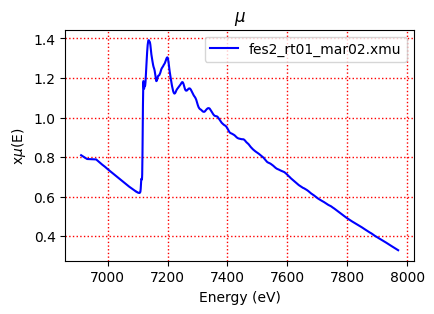

In [3]:
# fe_xas is not an input 
# it is an intermediate output from the read operation,
# its evolution is preserved into the athena project and the plots
fe_xas=None

# read ascii files
# labels tell the reader how to name the resulting columns
# eneregy and mu are the most important labels
input_file = Path(data_location,fes2_file)
fe_xas = read_ascii(input_file, labels = data_labels)


# show_data(fe_xas)
plot_mu([fe_xas],4.5,3)

### 2. Background removal and Fourier transform.
Find a set of parameters that gives a good background removal and Fourier transform. Note that the first few data points in the pre-edge are odd – be sure to select pre-edge parameters that avoid that bit of data.

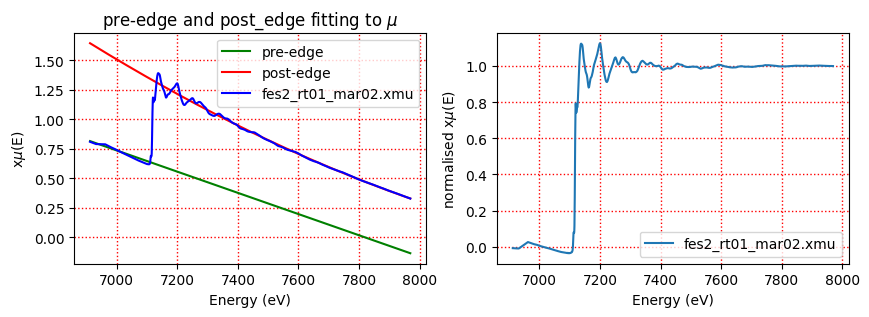

In [4]:
# calculate pre-edge and post edge and add them to group
# we want to avoid the data below E0 - 117.00
pre_edge(fe_xas, group=fe_xas)

plot_mu_and_norm([fe_xas],10,3)

The initial values of the data skew the pre-edge fitting and affect the normalisation. Setting the pre-edge values to exclude those initial values corrects this issue.

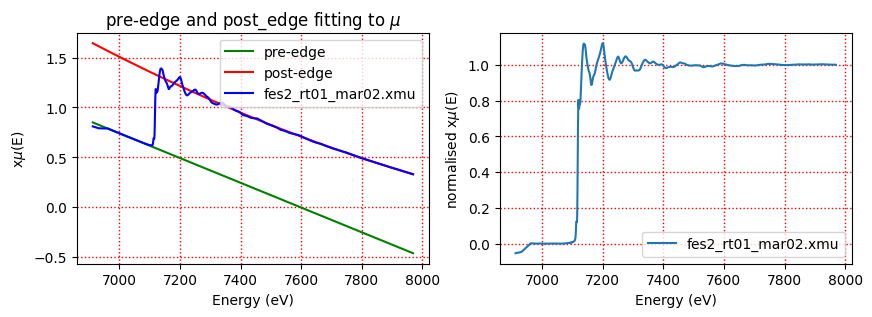

In [5]:
# normalise setting pre_edge to [-117,-30] 
pre_edge(fe_xas, group=fe_xas, pre1=-117, pre2=-30)
    
plot_mu_and_norm([fe_xas],10,3)    
#plot_mu_pre_post(fe_xas)
#plot_normalised(fe_xas)

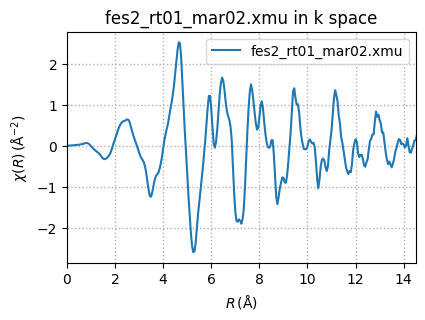

In [6]:
autobk(fe_xas, rbkg=1.0)
plot_in_k([fe_xas],4.5,3)

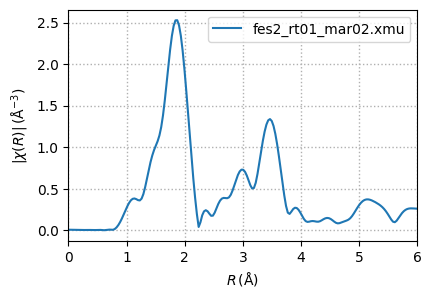

In [7]:
xftf(fe_xas)#, kweight=0.5, kmin=2.0, kmax=15, dk=4, kwindow='Hanning')
# Larch defaults seem to work better than trying to force athena default values
plot_in_r([fe_xas],4.5,3)

### 3. Save Athena Project

In [8]:
# save as an athena project
project_name = Path(data_location,'fes2.prj')
fe_project = create_athena(project_name)
fe_project.add_group(fe_xas)
fe_project.save()
vars(fe_project)

{'_larch': None,
 'groups': OrderedDict([('fes2_rt01_mar02_xmu', <Group 0x19c40ebf370>),
              ('hvuem', <Group ascii_file data\fes2_rt01_mar02.xmu>)]),
 'header': '# Athena project file -- Demeter version 0.9.24\n# This file created at 2024-06-10T18:32:50\n# Using Larch version 0.9.71, Python 3.9.2rc1 on Windows-10-10.0.22621-SP0\n',
 'journal': '',
 'filename': WindowsPath('data/fes2.prj'),
 'group_names': ['fes2_rt01_mar02_xmu']}

### 4-5. Fire up Artemis and  Import data from Athena file.
In this case we keep using Larch, as it can also handle EXAFS fitting using feff.
The same defaults as the Artemis are stored so that the 

In [9]:
athena_file =  project_name
athena_prj = athenamgr.read_project(athena_file)

athena_groups = athenamgr.get_groups(athena_prj)

group_names = []
for a_group in athena_groups:
    group_names.append(a_group.label)
    
group_names

# recalculate norm, background removal and fourier transform 
# with defaults
data_group = athenamgr.calc_with_defaults(athena_groups[0])

# start a larch session to manage fit and paths
session = Interpreter()

# variables for fit
fit_vars = {}
fit_vars['fitspace']='r'
fit_vars['kmin']=3 
fit_vars['kmax']=14
fit_vars['kw']=2 
fit_vars['dk']=1
fit_vars['window']='hanning'
fit_vars['rmin']=1.4
fit_vars['rmax']=3.0



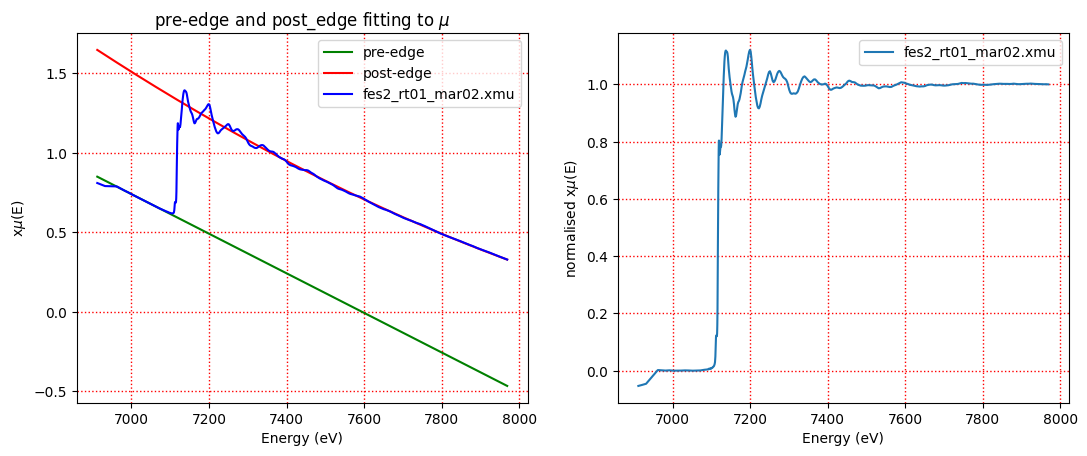

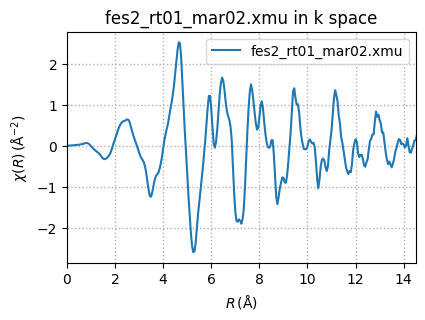

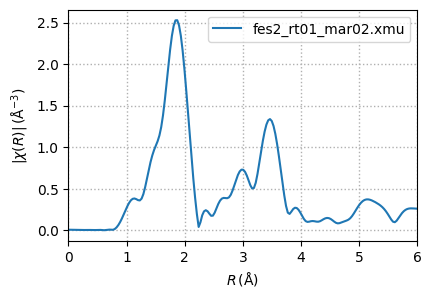

In [10]:
# show that the project saves the processing (pre-edge settings, normalisation, etc)
plot_mu_and_norm(athena_groups)
plt.show()
plot_in_k(athena_groups,4.5,3)
plot_in_r(athena_groups,4.5,3)

### 6-7 Import FeS<sub>2</sub> adn run FEFF
Import the crystallographic data contained in the file FeS2.inp. Run Atoms. Note that you can set the cluster size independently of Rmax, the length of the longest path to be calculated.
Verify that the Feff input data is reasonable, then run Feff.

In [11]:
# run feff and get a list of feff dirs
crystals = [Path(data_location,fes2_structure)]
feff_dirs = feff_runner.run_feff(crystals)

Processing: data\FeS2.inp
check if need to build: FeS2_feff
copying: FeS2.inp  to  FeS2_feff\FeS2_feff.inp
 : ======== running Feff module C:\Users\scman1\AppData\Local\Programs\Python\Python39\lib\site-packages\larch\bin\win64\feff6l.exe ========
 : Feff 6L.02
 : name:     Iron sulfide (pyrite)
 : formula:  FeS_2
 : refer1:   Elliot (1960) J.Chem. Phys. 33(3), 903.
 : Calculating potentials and phases...
 : free atom potential and density for atom type    0
 : free atom potential and density for atom type    1
 : free atom potential and density for atom type    2
 : overlapped potential and density for unique potential    0
 : overlapped potential and density for unique potential    1
 : overlapped potential and density for unique potential    2
 : muffin tin radii and interstitial parameters
 : phase shifts for unique potential    0
 : phase shifts for unique potential    1
 : phase shifts for unique potential    2
 : Preparing plane wave scattering amplitudes...
 : nncrit in prcrit 

### Select Paths
Select the first 11 paths in the path interpretation by setting the value of the select columt to 1 (0 means not selected) then run the code cell a bellow the table to update the "selected paths"  varaible and save the values to the csv file.

In [12]:
# read saved selected paths from input file
sel_paths_csv = Path(data_location,spl_file)
selected_paths = fit_manager.read_selected_paths_list(sel_paths_csv, session)

path_sheet = fit_manager.show_feff_paths(crystals, selected_paths)
display(path_sheet)

Sheet(cells=(Cell(column_end=7, column_start=0, row_end=48, row_start=0, squeeze_column=False, squeeze_row=Fal…

In [13]:
# show the selected paths and allow assigninh GDS variables
# in this case only sigma2 varies
sp_sheet = fit_manager.show_selected_paths(path_sheet, selected_paths)

Sheet(cells=(Cell(column_end=5, column_start=0, row_end=11, row_start=0, squeeze_column=False, squeeze_row=Fal…

In [14]:
# read the paths from the path sheet
selected_paths = fit_manager.build_selected_paths_list(path_sheet, session)
#selected_paths = local_build_selected_paths_list(sp_sheet, session)
# save the selected paths to the csv file
fit_manager.save_selected_paths_list(sp_sheet, sel_paths_csv)
# read the selected paths from the file (not needed, just checking that the data is saved)
selected_paths = fit_manager.read_selected_paths_list(sel_paths_csv, session)

In [15]:
# read saved selected paths from input file
fit_gds_variables_csv = Path(data_location,gds_file)

# read save parameters from input gds file
gds = fit_manager.read_gds(fit_gds_variables_csv, session)
# show gsd group parameters in a spreadsheet
this_sheet = fit_manager.show_gds(gds)


Sheet(cells=(Cell(column_start=0, row_end=25, row_start=0, squeeze_column=False, squeeze_row=False, value=[['i…

In [16]:
#read the gds data and save it to the csv file
gds = fit_manager.spreadsheet_to_gds(this_sheet, session)
# save gsd group parameters in a csv file
fit_manager.save_gds(gds, fit_gds_variables_csv)

In [17]:
gds

<Param Group 0x19c6af26d30>

In [18]:
# run fit
trans, dset, out = fit_manager.run_fit(data_group, gds, selected_paths, fit_vars, session)

ValueError: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.